# Pneumonia Classification

Guided project from Coursera

By: Ana María Garzón Sánchez

Developed in Google Colab

Importing Libraries:

All libraries are already available at Google Colab except for timm, so it is necessary to install it first

In [1]:
!pip install timm

Now we can import the libraries. Notice that **helper** is not an automatically loaded library, you have to add it to the files. It is in the files in the repository.

In [2]:
import torch
import numpy as np
import matplotlib as plt
import os
from tqdm.notebook import tqdm
from torchvision import transforms as T, datasets
from helper import show_image, show_grid, accuracy, view_classify
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
import torch.nn.functional as F
import timm
from torchsummary import summary
from tqdm import tqdm

### Configuration class

In this class, you'll see the epocs, learning rate, batch size, model name (we are going to use efficient net pretrained model, from timm **IT IS IMPORTANT TO HAVE THE HUGGING FACE API IN THE COLAB SECRETS TO LOAD THE MODEL**), image size and the data directory.

In my case I downloaded the image dataset from Kaggle and added it to my personal Google Drive and I used drive.mount to access it. How ever there are multiple ways to access the files.

This is the dataset link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

In [3]:
drive.mount("/content/drive") # Access drive folder for Google Colab

class CFG:
  epochs = 10
  lr = 0.001
  batch_size = 16
  model_name = 'tf_efficientnet_b4'
  img_size = 224

  # DATA DIRECTORY
  DATA_DIR = '/content/drive/My Drive/chest_x_ray_images/chest_xray_data'
  TEST = 'test'
  TRAIN = 'train'
  VAL = 'val'

Mounted at /content/drive


Now we set up the device. This step is important because it is crucial to have the both the model, and the data on the same device, either CPU or GPU, for the model to process data. Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("On which devide we are on : {}".format(device))

On which devide we are on : cpu


### Image Transformation and Load Dataset

We'll create the transform for train, validation and test dataset. Notice that in train-transform, we rotate the images randomly 20 degrees to the left or to the right, in order to augmentate the variability without increasing the number of samples.

In [5]:
train_transform = T.Compose([
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

The next step is to use the CFG class to get the information from the folders and then transform it with the previous code.

In [6]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path, transform = train_transform)
validset = datasets.ImageFolder(valid_path, transform = valid_transform)
testset = datasets.ImageFolder(test_path, transform = test_transform)

Now we are going to see the train, validation and test sets sizes.

In [7]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5227
Validset Size : 16
Testset Size : 634


We are going to test if the images were loaded and rotated correctly by displaying one of the images.

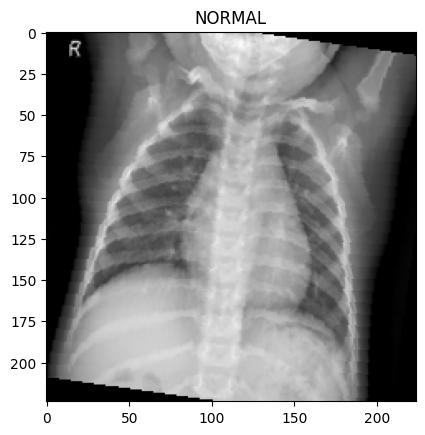

In [8]:
image, label = trainset[2]
class_name = ['NORMAL','PNEUMONIA']
show_image(image,class_name[label])

## Load Dataset into Batches

Now, using DataLoader we are going to create our 16 sized batches for the train, validation and test sets.

In [9]:
trainloader = DataLoader(trainset, batch_size = CFG.batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = CFG.batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = CFG.batch_size, shuffle = True)

Now we can observe that the number of batches in trainloader is approximately the number of total examples over 16:

In [10]:
print("No. of batches in trainloader: {}".format(len(trainloader)))
print("No. of Total examples: {}".format(len(trainloader.dataset)))

No. of batches in trainloader: 327
No. of Total examples: 5227


Now, we can see how a batch is integrated:

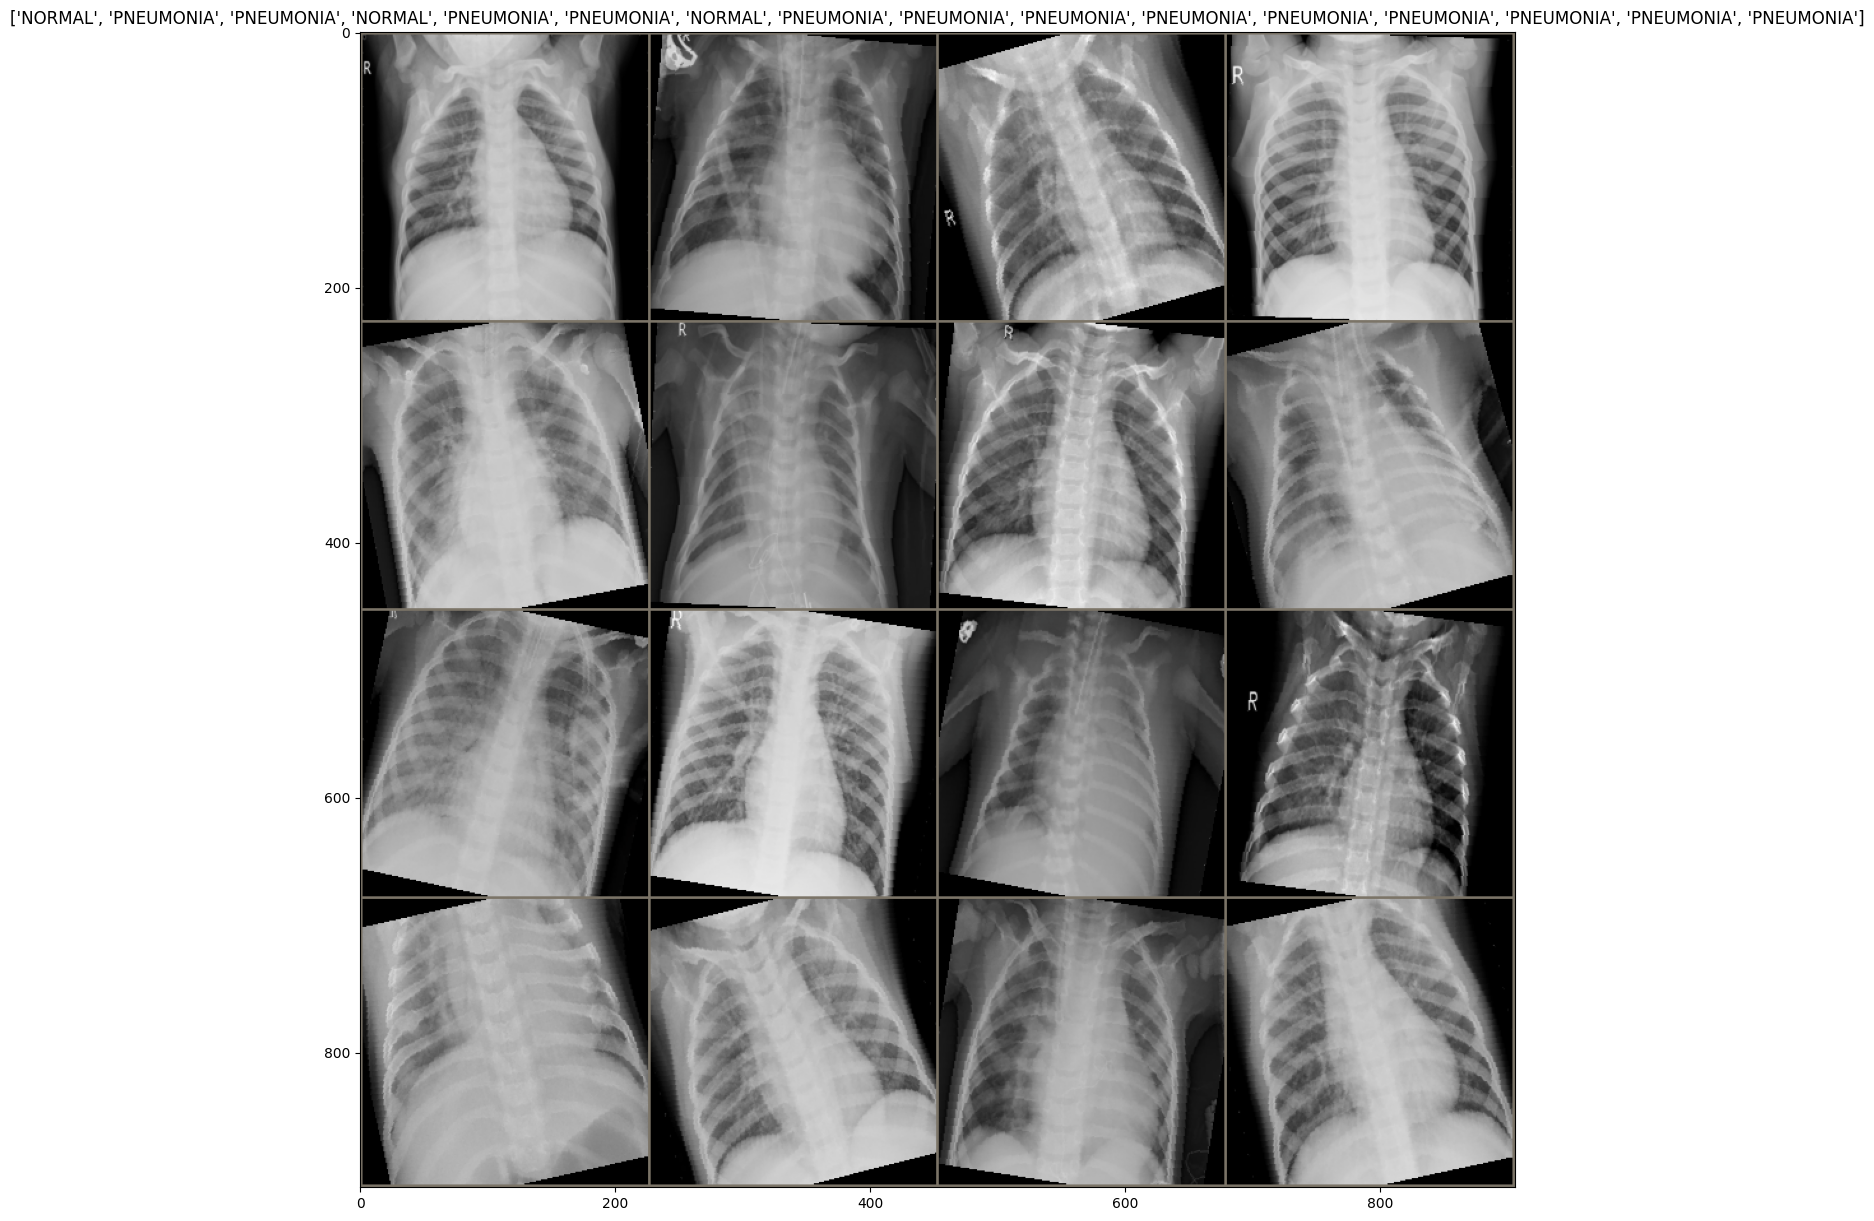

In [11]:
dataiter = iter(trainloader)
images,labels = next(dataiter)
out = make_grid(images,nrow=4)
show_grid(out,title = [class_name[x] for x in labels])

## Fine Tuning EfficientNet Model

In this section we will fine tune the pretrained EfficientNet Model with the following features:

In [12]:
model = timm.create_model(CFG.model_name, pretrained = True)

for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features = 1792, out_features = 625),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features = 625, out_features = 256),
    nn.ReLU(),
    nn.Linear(in_features = 256, out_features = 2)
)

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

And we can obtain a summary of how the model is composed with our tuning:

In [13]:
summary(model,input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

## Build a Simple Trainer

In this section we will create a very simple trainer class for pytorch. The class initialization will get a criterion, an optimizer and a schedular. Then we have a train_batch_loop and valid_batch_loop methods that we will later use in the fit method that is basically the method for training the model.

In [14]:
class PneumoniaTrainer():
  def __init__(self, criterion, optimizer, schedular = None):
    self.criterion = criterion
    self.optimizer = optimizer
    self.schedular = schedular

  def train_batch_loop(self, model, trainloader):
    train_acc = 0.0
    train_loss = 0.0

    for images, labels in tqdm(trainloader):
      images = images.to(device)
      labels = labels.to(device)
      logits = model(images)
      loss = self.criterion(logits,labels)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      train_loss += loss.item()
      train_acc += accuracy(logits, labels)

    return train_loss / len(trainloader), train_acc / len(trainloader)

  def valid_batch_loop(self, model, validloader):
    valid_acc = 0.0
    valid_loss = 0.0

    for images, labels in tqdm(validloader):
      images = images.to(device)
      labels = labels.to(device)
      logits = model(images)
      loss = self.criterion(logits, labels)

      valid_loss += loss.item()
      valid_acc += accuracy(logits, labels)

    return valid_loss / len(validloader), valid_acc / len(validloader)

  def fit(self, model, trainloader, validloader, epochs):

    model = model.to(device)
    model.float()

    valid_min_loss = np.Inf

    for i in range(epochs):
      model.train()
      avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
      model.eval()
      avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)

      if avg_valid_loss <= valid_min_loss:
        print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
        torch.save(model.state_dict(), 'PneumoniaModel.pt')
        valid_min_loss = avg_valid_loss

      print("Epoch: {} Train Loss : {} Train Acc : {}".format(i+1, avg_train_loss, avg_train_acc))
      print("Epoch: {} Valid Loss : {} Valid Acc : {}".format(i+1, avg_valid_loss, avg_valid_acc))

## Training Model



Now we set the criterion as CrossEntropyLoss and the optimizer as Adam. We initialize an object of the PneumoniaTrainer class and then we fit it. As it has 20 epochs and it takes around X minutes to train, I included the trained model in the files.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validloader,epochs = CFG.epochs)

100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Valid loss decreased inf --> 0.667873740196228
Epoch: 1 Train Loss : 0.24954758008047712 Train Acc : 0.8953641653060913
Epoch: 1 Valid Loss : 0.667873740196228 Valid Acc : 0.6875


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


Valid loss decreased 0.667873740196228 --> 0.43678635358810425
Epoch: 2 Train Loss : 0.2005056813473184 Train Acc : 0.9207846522331238
Epoch: 2 Valid Loss : 0.43678635358810425 Valid Acc : 0.8125


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Epoch: 3 Train Loss : 0.19222411423329183 Train Acc : 0.9256672263145447
Epoch: 3 Valid Loss : 0.6611304879188538 Valid Acc : 0.6875


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch: 4 Train Loss : 0.17428266877074947 Train Acc : 0.9311057925224304
Epoch: 4 Valid Loss : 0.6080636382102966 Valid Acc : 0.625


100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Epoch: 5 Train Loss : 0.16729340220969569 Train Acc : 0.9334862232208252
Epoch: 5 Valid Loss : 0.5106655359268188 Valid Acc : 0.875


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Epoch: 6 Train Loss : 0.17673156807620635 Train Acc : 0.9338685274124146
Epoch: 6 Valid Loss : 0.5419899821281433 Valid Acc : 0.8125


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Epoch: 7 Train Loss : 0.16570743747818817 Train Acc : 0.9330170750617981
Epoch: 7 Valid Loss : 0.49465489387512207 Valid Acc : 0.625


100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Epoch: 8 Train Loss : 0.17329917776908169 Train Acc : 0.9335035681724548
Epoch: 8 Valid Loss : 0.6266318559646606 Valid Acc : 0.6875


100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch: 9 Train Loss : 0.15176011175088105 Train Acc : 0.9389421939849854
Epoch: 9 Valid Loss : 0.667633056640625 Valid Acc : 0.5625


100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

Epoch: 10 Train Loss : 0.1582690717507188 Train Acc : 0.9401758313179016
Epoch: 10 Valid Loss : 0.45189541578292847 Valid Acc : 0.75


## Plot Results

Now we are going to use the test set to see how the model did

In [16]:
model.load_state_dict(torch.load("/content/PneumoniaModel.pt"))
model.eval()
avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)

print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))

100%|██████████| 40/40 [09:41<00:00, 14.54s/it]

Test Acc : 0.8512499928474426
Test Loss : 0.34888611882925036


We can see that we obtained a pretty good accuracy for this case. In case you want to test it with an specific image you can use the following visualization:

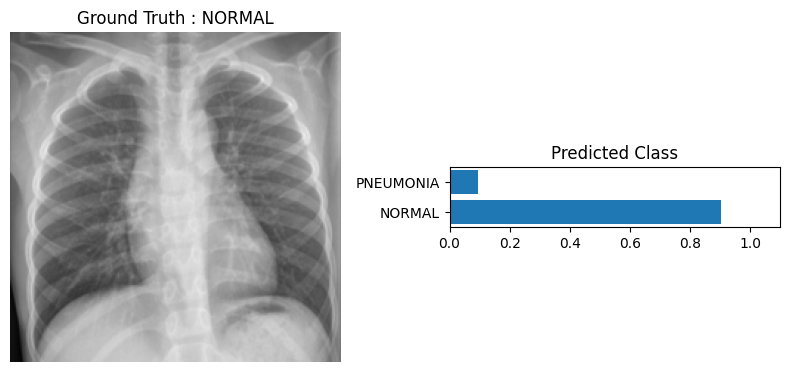

In [17]:
image, label = testset[3]
logit = model(image.to(device).unsqueeze(0))
ps = F.softmax(logit, dim = 1)
view_classify(image, ps,label)